In [ ]:
#%pip install -U scikit-learn
#%pip install lightgbm
#%pip install shap
#%pip install ipywidgets

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import shap
import lightgbm as lgb
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score,confusion_matrix, ConfusionMatrixDisplay,precision_recall_curve
from sklearn.model_selection import TimeSeriesSplit
import gc

In [2]:
df:pd.DataFrame = pd.read_parquet('./data/clean_data/final/final_df.parquet')

In [14]:
del df
gc.collect()

25988

# Trenowanie 1 modelu

In [ ]:

# Wybór cech (Feature Selection) - Usuwanie "leakow"
# Zostaje tylko to, co wiemy PRZED startem samolotu.
drop_cols = [
    'ArrDel15', 'ArrDelay', 'ArrDelayMinutes', 'ArrTime', 
    'DepTime', 'DepDelay', 'DepDelayMinutes', 'DepDel15',
    'ActualElapsedTime', 'AirTime',
    'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'
]


meta_cols = ['Flight_Number_Operating_Airline', 'Tail_Number', 'icao24', 'owner']

target = 'ArrDel15'

# 2. Przygotowanie danych
df = df.dropna(subset=[target])
df[target] = df[target].astype(int)

# 3. Podział Time Series Split
# Przy danych lotniczych najlepiej dzielić po dacie, a nie losowo.
# Przykład: Trenujemy na pierwszych 9 miesiącach, testujemy na końcówce roku.
df = df.sort_values('FlightDate')
split_date = df['FlightDate'].iloc[int(len(df) * 0.8)] # 80% trening, 20% test

train = df[df['FlightDate'] < split_date].copy()
test = df[df['FlightDate'] >= split_date].copy()

X_train = train.drop(columns=drop_cols + meta_cols + ['FlightDate'])
y_train = train[target]

X_test = test.drop(columns=drop_cols + meta_cols + ['FlightDate'])
y_test = test[target]

# 4. Automatyczne wykrywanie kolumn kategorycznych dla LightGBM
cat_features = X_train.select_dtypes(include=['category']).columns.tolist()

# 5. Tworzenie zbiorów Dataset (optymalizacja pamięciowa LightGBM)
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=cat_features, reference=train_data)

# 6. Parametry modelu
# scale_pos_weight pomaga, jeśli opóźnień jest mało (np. 20% zbioru)
params = {
    'objective': 'binary',
    'metric': 'auc', # lub 'binary_logloss'
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'n_jobs': -1,
    'scale_pos_weight': (len(y_train) - sum(y_train)) / sum(y_train) # Balansowanie klas
}

# 7. Trening
print("Rozpoczynam trenowanie modelu...")
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],
    valid_names=['train', 'valid'],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=50)
    ]
)

# 8. Ewaluacja
y_pred_prob = model.predict(X_test)
y_pred_class = (y_pred_prob > 0.5).astype(int)

print("\n--- RAPORT KLASYFIKACJI ---")
print(classification_report(y_test, y_pred_class))
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_prob):.4f}")
print(f"PR-AUC (Average Precision): {average_precision_score(y_test, y_pred_prob):.4f}")

# 9. Ważność cech
importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

print("\nTOP 10 najważniejszych cech:")
print(importance.head(10))

Rozpoczynam trenowanie modelu...
Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.718737	valid's auc: 0.662945
[100]	train's auc: 0.733746	valid's auc: 0.673864
[150]	train's auc: 0.741269	valid's auc: 0.678449
[200]	train's auc: 0.74607	valid's auc: 0.680756
[250]	train's auc: 0.749636	valid's auc: 0.683262
[300]	train's auc: 0.752656	valid's auc: 0.684257
[350]	train's auc: 0.754977	valid's auc: 0.685252
[400]	train's auc: 0.756889	valid's auc: 0.686537
[450]	train's auc: 0.758768	valid's auc: 0.686996
[500]	train's auc: 0.760335	valid's auc: 0.687456
[550]	train's auc: 0.761811	valid's auc: 0.687983
Early stopping, best iteration is:
[543]	train's auc: 0.761618	valid's auc: 0.688132

--- RAPORT KLASYFIKACJI ---
              precision    recall  f1-score   support

           0       0.88      0.79      0.83    633665
           1       0.31      0.46      0.37    131535

    accuracy                           0.73    765200
   macro avg       0.59   

# Zaawansowany Time Series Split

In [ ]:
df = df.sort_values('FlightDate').reset_index(drop=True)

target = 'ArrDel15'

# Usuwamy kolumny, które powodowałyby wyciek danych (Data Leakage)
cols_to_drop = [
    target, 'ArrDelay', 'ArrDelayMinutes', 'ActualElapsedTime', 
    'AirTime', 'ArrTime', 'DepTime', 'DepDelay','DepDel15' 'DepDelayMinutes',
    'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 
    'LateAircraftDelay', 'FlightDate','Tail_Number','icao24' # Datę usuwamy po posortowaniu
]

X = df.drop(columns=cols_to_drop)
y = df[target].astype(int) # Konwersja boolean na int (0/1)

# 2. Konfiguracja TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Parametry LightGBM (bazowe, zoptymalizowane pod duże zbiory)
params = {
    'objective': 'binary',
    'metric': 'auc',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'random_state': 42,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'n_jobs': -1 # Wykorzystaj wszystkie rdzenie
}

print(f"Rozpoczynam walidację krzyżową (TimeSeriesSplit)...")

# 3. Pętla treningowa
fold = 1
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Tworzenie zbiorów danych LightGBM
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
    
    # Trening modelu
    model = lgb.train(
        params,
        train_data,
        num_boost_round=1000,
        valid_sets=[train_data, valid_data],
        valid_names=['train', 'valid'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=100)
        ]
    )
    
    # Predykcje
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)
    
    auc_score = roc_auc_score(y_test, y_pred_prob)
    print(f"\n--- Fold {fold} ---")
    print(f"AUC: {auc_score:.4f}")
    print(classification_report(y_test, y_pred))
    fold += 1

Rozpoczynam walidację krzyżową (TimeSeriesSplit)...
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.925899	valid's auc: 0.908178
[200]	train's auc: 0.934108	valid's auc: 0.908528
Early stopping, best iteration is:
[172]	train's auc: 0.932585	valid's auc: 0.908632

--- Fold 1 ---
AUC: 0.9086
              precision    recall  f1-score   support

           0       0.94      0.95      0.94    500545
           1       0.80      0.78      0.79    136890

    accuracy                           0.91    637435
   macro avg       0.87      0.86      0.87    637435
weighted avg       0.91      0.91      0.91    637435

Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.919452	valid's auc: 0.908543
[200]	train's auc: 0.927551	valid's auc: 0.910145
[300]	train's auc: 0.931873	valid's auc: 0.91065
[400]	train's auc: 0.934531	valid's auc: 0.911001
[500]	train's auc: 0.936553	valid's auc: 0.911273
Early stopping, best iteration is:
[4

In [8]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(), X.columns)), columns=['Value','Feature'])

feature_imp.sort_values(by="Value", ascending=False).head(20)

,Value,Feature
43,1517,Dest
42,1320,Origin
41,756,model
40,377,origin_tmpf
39,342,DayofMonth
38,329,Month
37,326,CRSArrTime
36,281,dest_tmpf
35,206,CRSDepTime
34,193,CRSElapsedTime


In [13]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot(cmap=plt.cm.Blues)
# plt.show()
cm

array([[493341,  28280],
       [ 26058,  89756]])

# Propagated Delay

In [3]:
# 1. Sortujemy dane chronologicznie dla każdego samolotu
df = df.sort_values(by=['Tail_Number', 'FlightDate', 'CRSDepTime'])

# 2. Tworzymy zmienną "Propagated Delay" (Opóźnienie w minutach poprzedniego lotu danej maszyny)
# Używamy shift(1), aby pobrać wynik z poprzedniego wiersza dla danego Tail_Number
df['Prev_Flight_ArrDelay'] = df.groupby('Tail_Number')['ArrDelayMinutes'].shift(1)

# Dla pierwszego lotu danego dnia/samolotu nie mamy historii, wypełniamy 0
df['Prev_Flight_ArrDelay'] = df['Prev_Flight_ArrDelay'].fillna(0)

# Możemy też dodać flagę, czy poprzedni lot był opóźniony > 15 min
df['Prev_Flight_Del15'] = (df['Prev_Flight_ArrDelay'] > 15).astype(int)

In [4]:
# Zdefiniowanie cech do modelu (usuwamy wycieki danych!)
features_to_drop = [
    'DepTime', 'DepDelay', 'DepDelayMinutes', 'DepDel15', 
    'ArrTime', 'ArrDelay', 'ArrDelayMinutes', 'ArrDel15', 
    'ActualElapsedTime', 'AirTime', 'CarrierDelay', 'WeatherDelay', 
    'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'FlightDate' # FlightDate nie wrzucamy bezpośrednio
]

# Cel predykcji
target = 'ArrDel15'

# Rzutowanie zmiennej docelowej na int (z boolean)
df[target] = df[target].astype(int)

# Podział w oparciu o miesiące
train_df = df[df['Month'] <= 10]
valid_df = df[df['Month'] == 11]
test_df  = df[df['Month'] == 12]

X_train = train_df.drop(columns=features_to_drop)
y_train = train_df[target]

X_valid = valid_df.drop(columns=features_to_drop)
y_valid = valid_df[target]

X_test = test_df.drop(columns=features_to_drop)
y_test = test_df[target]

# Konwersja kolumn typu string/object na 'category' dla LightGBM
for c in X_train.select_dtypes(include=['string', 'object']).columns:
    X_train[c] = X_train[c].astype('category')
    X_valid[c] = X_valid[c].astype('category')
    X_test[c] = X_test[c].astype('category')

# Definicja parametrów LightGBM
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 63,
    'max_depth': 8,
    'min_data_in_leaf': 100,
    'feature_fraction': 0.8,
    'is_unbalance': True,  # Ważne dla opóźnień, które są w mniejszości
    'cat_smooth': 50,      # Rozwiązuje problem dominacji Origin/Dest
    'random_state': 42,
    'verbose': -1
}

# Tworzenie struktur danych DMatrix/Dataset
lgb_train = lgb.Dataset(X_train, y_train)
lgb_valid = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

# Trenowanie modelu
print("Rozpoczynam trenowanie modelu...")
model = lgb.train(
    params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_train, lgb_valid],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(50)
    ]
)

# Ewaluacja na zbiorze testowym (Grudzień)
preds_proba = model.predict(X_test)
preds_class = (preds_proba > 0.5).astype(int)

print("\n--- Wyniki dla Grudnia ---")
print(f"ROC AUC Score: {roc_auc_score(y_test, preds_proba):.4f}")
print(classification_report(y_test, preds_class))

Rozpoczynam trenowanie modelu...
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.782884	valid_1's auc: 0.74644
[100]	training's auc: 0.79475	valid_1's auc: 0.750976
[150]	training's auc: 0.801496	valid_1's auc: 0.752195
[200]	training's auc: 0.806155	valid_1's auc: 0.753548
[250]	training's auc: 0.810094	valid_1's auc: 0.754331
[300]	training's auc: 0.813291	valid_1's auc: 0.754629
[350]	training's auc: 0.81653	valid_1's auc: 0.754828
Early stopping, best iteration is:
[321]	training's auc: 0.814588	valid_1's auc: 0.754845

--- Wyniki dla Grudnia ---
ROC AUC Score: 0.7581
              precision    recall  f1-score   support

           0       0.87      0.86      0.86    252612
           1       0.50      0.51      0.50     67858

    accuracy                           0.79    320470
   macro avg       0.68      0.68      0.68    320470
weighted avg       0.79      0.79      0.79    320470



--- Tabela Ważności Cech (Top 20 wg Gain) ---
                 Feature          Gain  Split
0   Prev_Flight_ArrDelay  4.323503e+06    758
1             CRSDepTime  1.745043e+06    873
2      Prev_Flight_Del15  1.586356e+06     38
3             CRSArrTime  1.405640e+06    662
4                 Origin  1.087771e+06   2726
5                   Dest  9.635503e+05   2681
6            Tail_Number  9.570794e+05   3076
7                  Month  7.849939e+05    780
8          origin_precip  4.319301e+05    289
9      Operating_Airline  4.072826e+05    367
10           origin_tmpf  3.526518e+05    769
11           dest_precip  3.064544e+05    222
12                 model  2.781829e+05   1184
13            DayofMonth  2.638797e+05    886
14                icao24  1.887230e+05    596
15   origin_thunderstorm  1.684721e+05    108
16             DayOfWeek  1.525121e+05    400
17           origin_vsby  1.420745e+05    221
18             dest_tmpf  1.060760e+05    541
19               Quarter  1.043940

C:\Users\jakub\AppData\Local\Temp\ipykernel_1800\302957601.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


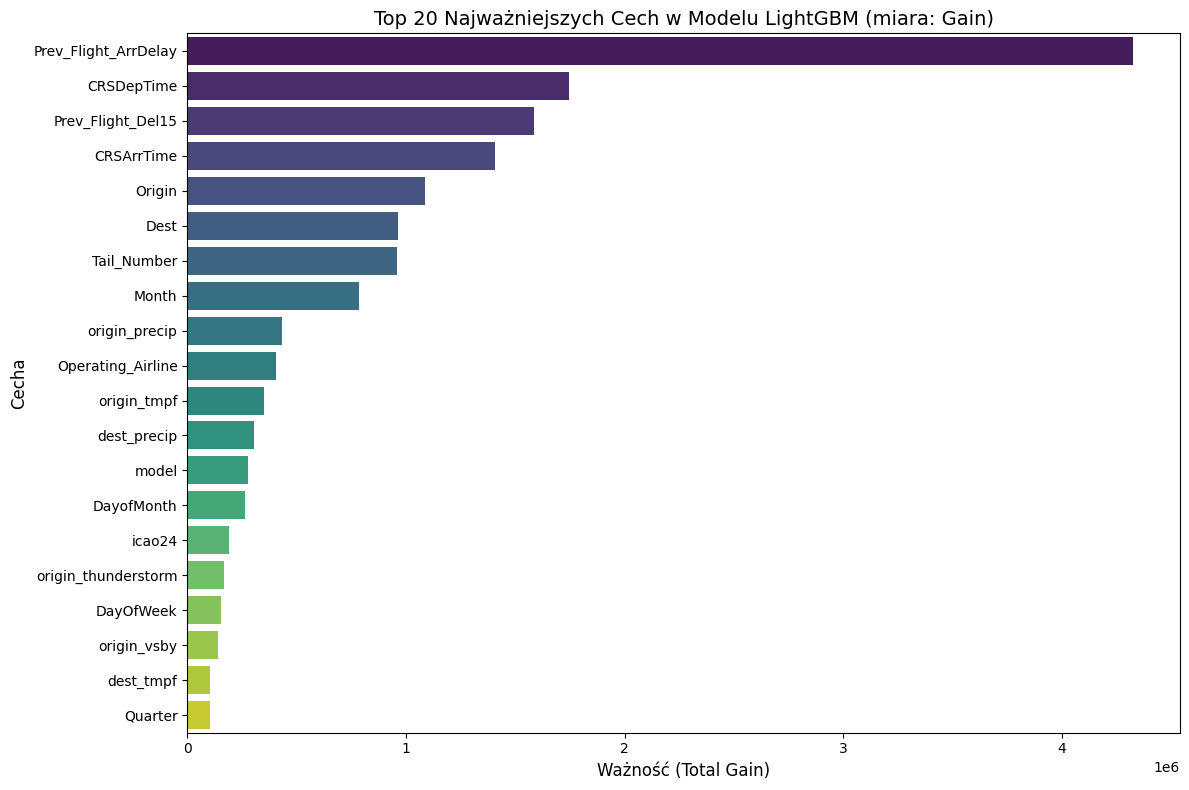

In [5]:
features = model.feature_name()

# 2. Pobranie ważności cech w obu miarach: 'gain' oraz 'split'
importances_gain = model.feature_importance(importance_type='gain')
importances_split = model.feature_importance(importance_type='split')

# 3. Utworzenie tabeli (DataFrame) z wynikami
feature_imp_df = pd.DataFrame({
    'Feature': features,
    'Gain': importances_gain,
    'Split': importances_split
})

# 4. Sortowanie tabeli według najważniejszej miary (Gain) malejąco
feature_imp_df = feature_imp_df.sort_values(by='Gain', ascending=False).reset_index(drop=True)

# Wyświetlenie top 20 najważniejszych cech w formie tabeli
print("--- Tabela Ważności Cech (Top 20 wg Gain) ---")
print(feature_imp_df.head(20))

# 5. Rysowanie wykresu
plt.figure(figsize=(12, 8))
# Używamy seaborn dla estetycznego wyglądu, bierzemy tylko top 20 cech
sns.barplot(
    x='Gain', 
    y='Feature', 
    data=feature_imp_df.head(20), 
    palette='viridis' # Możesz zmienić paletę kolorów
)

plt.title('Top 20 Najważniejszych Cech w Modelu LightGBM (miara: Gain)', fontsize=14)
plt.xlabel('Ważność (Total Gain)', fontsize=12)
plt.ylabel('Cecha', fontsize=12)
plt.tight_layout() # Zapobiega ucinaniu długich nazw cech na osi Y

# Wyświetlenie wykresu
plt.show()

Domyślny próg (0.5000) -> F1-score: 0.5015
Optymalny próg (0.4730) -> F1-score: 0.5019
Przy optymalnym progu: Precision = 0.4663, Recall = 0.5434


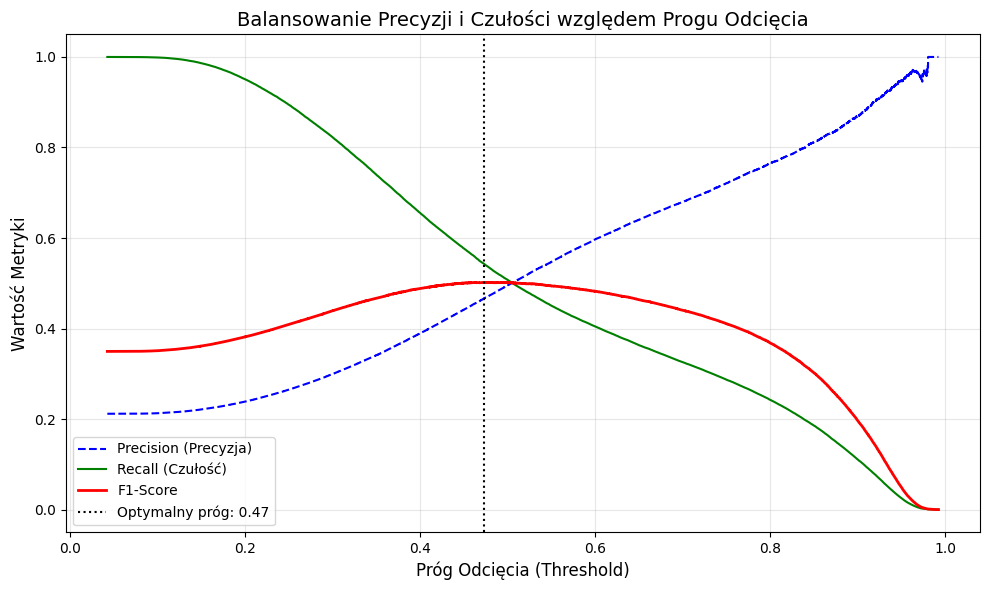

In [8]:
# 1. Obliczamy Precision i Recall dla wszystkich możliwych progów odcięcia
precisions, recalls, thresholds = precision_recall_curve(y_test, preds_proba)

# 2. Obliczamy F1-score dla każdego progu (unikamy dzielenia przez zero)
# Zabezpieczenie przed dzieleniem przez 0
numerator = 2 * (precisions[:-1] * recalls[:-1])
denominator = (precisions[:-1] + recalls[:-1])
f1_scores = np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator!=0)

# 3. Znajdujemy optymalny próg (najwyższe F1)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Domyślny próg (0.5000) -> F1-score: {f1_scores[np.abs(thresholds - 0.5).argmin()]:.4f}")
print(f"Optymalny próg ({optimal_threshold:.4f}) -> F1-score: {f1_scores[optimal_idx]:.4f}")
print(f"Przy optymalnym progu: Precision = {precisions[optimal_idx]:.4f}, Recall = {recalls[optimal_idx]:.4f}")

# 4. Rysowanie wykresu Precision-Recall w zależności od progu
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision (Precyzja)')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall (Czułość)')
plt.plot(thresholds, f1_scores, 'r-', label='F1-Score', linewidth=2)
plt.axvline(x=optimal_threshold, color='k', linestyle=':', label=f'Optymalny próg: {optimal_threshold:.2f}')

plt.title('Balansowanie Precyzji i Czułości względem Progu Odcięcia', fontsize=14)
plt.xlabel('Próg Odcięcia (Threshold)', fontsize=12)
plt.ylabel('Wartość Metryki', fontsize=12)
plt.legend(loc='lower left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Obliczanie wartości SHAP (to może potrwać kilkadziesiąt sekund)...


c:\Users\jakub\Desktop\Projekty\projekt-wlasny\.venv\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


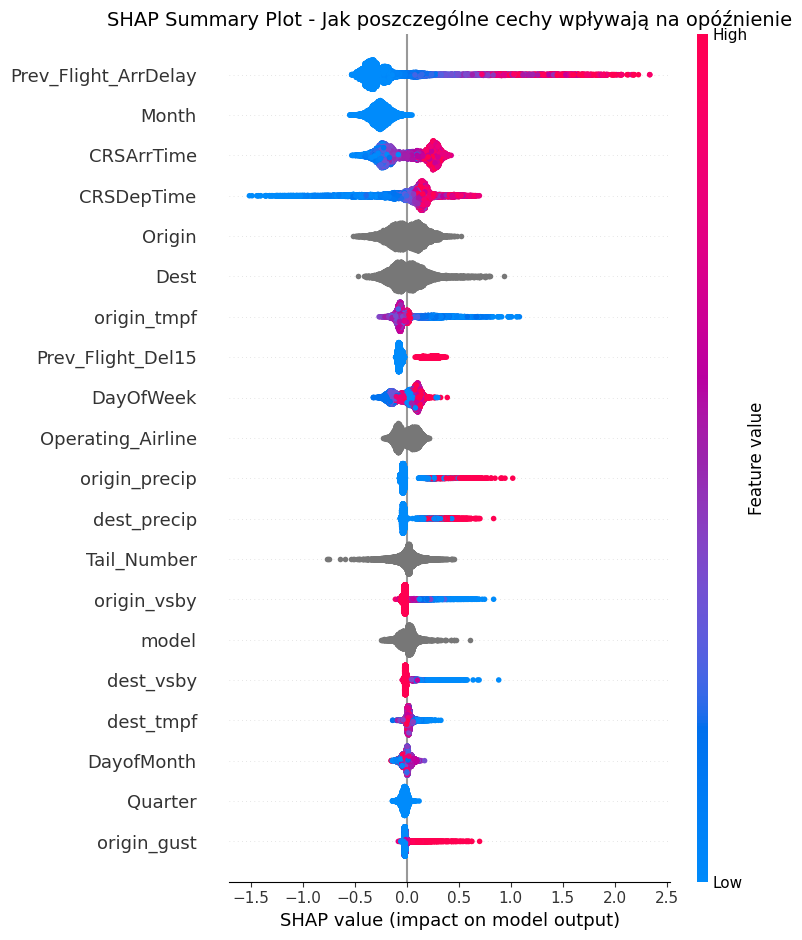

In [9]:
# 1. Losujemy próbkę danych ze zbioru testowego (żeby nie czekać godzinami)
X_test_sample = X_test.sample(n=10000, random_state=42)

# 2. Inicjalizacja TreeExplainer'a dla modelu LightGBM
print("Obliczanie wartości SHAP (to może potrwać kilkadziesiąt sekund)...")
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_sample)

# Uwaga dla klasyfikacji binarnej w LightGBM: 
# shap_values to często lista dwóch tablic (dla klasy 0 i klasy 1).
# Interesuje nas wpływ na klasę 1 (Opóźnienie), więc bierzemy shap_values[1].
# W nowszych wersjach pakietu shap może to być po prostu jedna tablica.
if isinstance(shap_values, list):
    shap_values_to_plot = shap_values[1]
else:
    shap_values_to_plot = shap_values

# 3. Rysowanie wykresu podsumowującego (Summary Plot)
plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values_to_plot, 
    X_test_sample, 
    max_display=20, # Pokazujemy top 20 cech
    show=False      # show=False pozwala nam dodać własny tytuł w matplotlib
)

plt.title('SHAP Summary Plot - Jak poszczególne cechy wpływają na opóźnienie', fontsize=14)
plt.tight_layout()
plt.show()

## Cost Matrix

In [12]:
# 1. Nasze założenia biznesowe (koszty w dolarach)
COST_TN = 0      # Prawidłowo punktualny (brak kosztów)
COST_FP = 500    # Fałszywy alarm
COST_TP = 2000   # Przewidziane opóźnienie (częściowo zminimalizowane straty)
COST_FN = 5000   # Zaskoczenie opóźnieniem (pełne koszty)

# 2. Ustawiamy próg zoptymalizowany pod F1
custom_threshold = 0.4730

# 3. Klasyfikacja lotów w oparciu o ten próg
preds_class_custom = (preds_proba > custom_threshold).astype(int)

# 4. Wyciągnięcie wartości z macierzy pomyłek
tn, fp, fn, tp = confusion_matrix(y_test, preds_class_custom).ravel()

# 5. Obliczenie kosztów cząstkowych
cost_tn = tn * COST_TN
cost_fp = fp * COST_FP
cost_tp = tp * COST_TP
cost_fn = fn * COST_FN

# Całkowity koszt
total_cost = cost_tn + cost_fp + cost_tp + cost_fn

# 6. Wyświetlenie czytelnego raportu
print(f"========== ANALIZA KOSZTÓW DLA PROGU {custom_threshold} ==========")
print(f"Liczba lotów w zbiorze grudniowym: {len(y_test):,}")
print("-" * 60)
print(f"True Negatives  (TN) - Prawidłowo punktualne : {tn:>7,} lotów -> Koszt: ${cost_tn:>11,.0f}")
print(f"False Positives (FP) - Fałszywe alarmy       : {fp:>7,} lotów -> Koszt: ${cost_fp:>11,.0f}")
print(f"True Positives  (TP) - Złapane opóźnienia    : {tp:>7,} lotów -> Koszt: ${cost_tp:>11,.0f}")
print(f"False Negatives (FN) - Przegapione opóźnienia: {fn:>7,} lotów -> Koszt: ${cost_fn:>11,.0f}")
print("-" * 60)
print(f"CAŁKOWITY KOSZT OPERACYJNY:                            ${total_cost:>11,.0f}")
print("============================================================")

========== ANALIZA KOSZTÓW DLA PROGU 0.473 ==========
Liczba lotów w zbiorze grudniowym: 320,470
------------------------------------------------------------
True Negatives  (TN) - Prawidłowo punktualne : 210,389 lotów -> Koszt: $          0
False Positives (FP) - Fałszywe alarmy       :  42,223 lotów -> Koszt: $ 21,111,500
True Positives  (TP) - Złapane opóźnienia    :  36,877 lotów -> Koszt: $ 73,754,000
False Negatives (FN) - Przegapione opóźnienia:  30,981 lotów -> Koszt: $154,905,000
------------------------------------------------------------
CAŁKOWITY KOSZT OPERACYJNY:                            $249,770,500


--- Symulacja Kosztów (Grudzień) ---
Koszt przy domyślnym progu (0.50): $253,454,000
Koszt przy OPTYMALNYM progu (0.32): $236,580,000
Oszczędności dzięki optymalizacji: $16,874,000


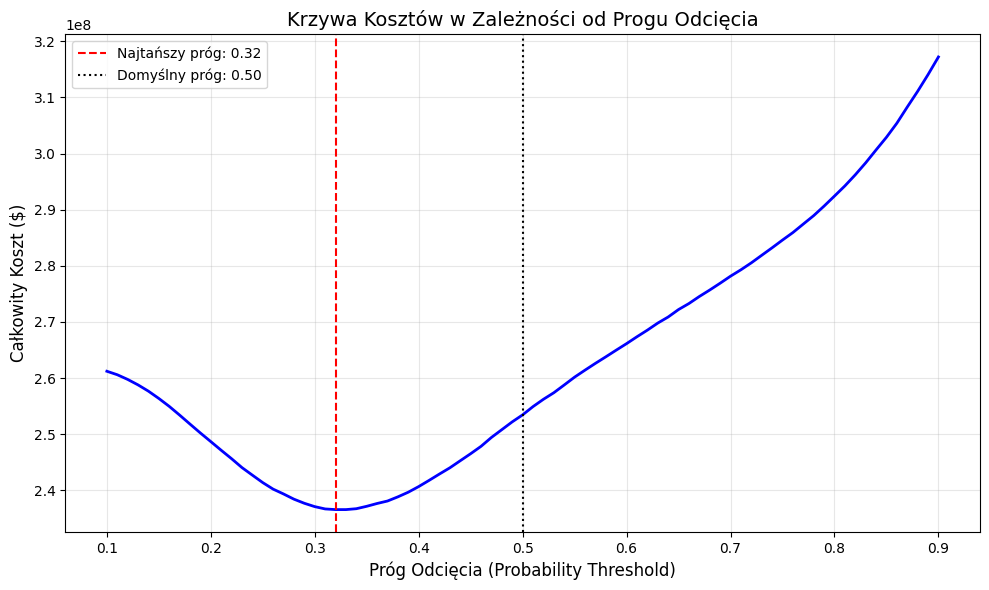

In [10]:
# 1. Definicja kosztów biznesowych (zmień według własnych ustaleń)
COST_TN = 0      # Prawidłowo punktualny
COST_FP = 500    # Fałszywy alarm
COST_TP = 2000   # Przewidziane opóźnienie (częściowo zminimalizowane straty)
COST_FN = 5000   # Zaskoczenie opóźnieniem (pełne koszty)

# 2. Generowanie listy progów do przetestowania (od 0.1 do 0.9)
thresholds = np.linspace(0.1, 0.9, 81)
total_costs = []

# 3. Pętla przeliczająca koszty dla każdego progu
for thresh in thresholds:
    # Przypisanie klas według testowanego progu
    preds_class = (preds_proba > thresh).astype(int)
    
    # Wyciągnięcie wyników z macierzy pomyłek
    # ravel() spłaszcza macierz 2x2 do 4 wartości
    tn, fp, fn, tp = confusion_matrix(y_test, preds_class).ravel()
    
    # Obliczenie całkowitego kosztu dla danego progu
    cost = (tn * COST_TN) + (fp * COST_FP) + (tp * COST_TP) + (fn * COST_FN)
    total_costs.append(cost)

# 4. Znalezienie optymalnego progu (najmniejszy koszt)
optimal_idx = np.argmin(total_costs)
optimal_threshold = thresholds[optimal_idx]
min_cost = total_costs[optimal_idx]

# Porównanie z domyślnym progiem 0.5
default_idx = np.abs(thresholds - 0.5).argmin()
default_cost = total_costs[default_idx]
savings = default_cost - min_cost

print(f"--- Symulacja Kosztów (Grudzień) ---")
print(f"Koszt przy domyślnym progu (0.50): ${default_cost:,.0f}")
print(f"Koszt przy OPTYMALNYM progu ({optimal_threshold:.2f}): ${min_cost:,.0f}")
print(f"Oszczędności dzięki optymalizacji: ${savings:,.0f}")

# 5. Rysowanie krzywej kosztów
plt.figure(figsize=(10, 6))
plt.plot(thresholds, total_costs, 'b-', linewidth=2)
plt.axvline(x=optimal_threshold, color='r', linestyle='--', label=f'Najtańszy próg: {optimal_threshold:.2f}')
plt.axvline(x=0.5, color='k', linestyle=':', label='Domyślny próg: 0.50')

plt.title('Krzywa Kosztów w Zależności od Progu Odcięcia', fontsize=14)
plt.xlabel('Próg Odcięcia (Probability Threshold)', fontsize=12)
plt.ylabel('Całkowity Koszt ($)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [13]:

# 1. Tworzymy kopię zbioru testowego (grudzień), aby nie zepsuć oryginalnych danych
results_df = test_df.copy()

# 2. Dodajemy nową kolumnę z wyliczonym przez model prawdopodobieństwem (0.0 - 1.0)
results_df['Risk_Probability'] = preds_proba

# 3. Wybieramy konkretny dzień, na który dyspozytorzy przygotowują plan (np. 15 grudnia)
target_day = 15
daily_plan_df = results_df[results_df['DayofMonth'] == target_day]

# 4. Sortujemy loty od tych z NAJWYŻSZYM prawdopodobieństwem opóźnienia
high_risk_flights = daily_plan_df.sort_values(by='Risk_Probability', ascending=False)

# 5. Wybieramy tylko te kolumny, które są kluczowe dla działu operacyjnego
# Zignorujemy tu kolumny techniczne czy pogodowe, damy im samo "mięso"
operational_columns = [
    'FlightDate', 
    'Operating_Airline', 
    'Flight_Number_Operating_Airline', 
    'Tail_Number', 
    'Origin', 
    'Dest', 
    'CRSDepTime', 
    'CRSArrTime', 
    'Risk_Probability'
]

# Pobieramy 100 najbardziej ryzykownych lotów
top_100_report = high_risk_flights[operational_columns].head(100)

# 6. Formatujemy prawdopodobieństwo na czytelne procenty (np. 0.854 -> '85.4%')
# Tworzymy kopię, żeby uniknąć ostrzeżeń z pandas (SettingWithCopyWarning)
top_100_report = top_100_report.copy()
top_100_report['Risk_Probability'] = (top_100_report['Risk_Probability'] * 100).round(1).astype(str) + '%'

# Wyświetlamy pierwsze 10 wierszy w konsoli, aby sprawdzić wynik
print(f"--- TOP 10 RYZYKOWNYCH LOTÓW NA DZIEŃ {target_day} GRUDNIA ---")
print(top_100_report.head(10).to_string(index=False))

# 7. Eksportujemy raport do pliku CSV lub Excel, który można wysłać mailem do zespołu!
raport_filename = f'Raport_Ryzyka_Lotow_Grudzien_{target_day}.csv'
top_100_report.to_csv(raport_filename, index=False)
print(f"\n✅ Raport wygenerowany i zapisany jako: {raport_filename}")

# Jeśli wolisz Excela (wymaga zainstalowanej biblioteki openpyxl: pip install openpyxl):
# top_100_report.to_excel(f'Raport_Ryzyka_Lotow_Grudzien_{target_day}.xlsx', index=False)

--- TOP 10 RYZYKOWNYCH LOTÓW NA DZIEŃ 15 GRUDNIA ---
FlightDate Operating_Airline  Flight_Number_Operating_Airline Tail_Number Origin Dest  CRSDepTime  CRSArrTime Risk_Probability
2024-12-15                OO                             3630      N837SK    BTV  DTW        1646        1901            97.7%
2024-12-15                WN                             4887      N924WN    PWM  BWI        1810        1950            97.7%
2024-12-15                OO                             5600      N970SW    MKE  ORD        1330        1438            97.7%
2024-12-15                ZW                             6047      N410AW    DSM  ORD        1515        1656            97.6%
2024-12-15                AA                             1460      N708UW    MSY  PHL        1629        2015            97.5%
2024-12-15                OH                             5129      N567NN    CHS  CLT        1825        1938            97.4%
2024-12-15                AA                             2